# Notebook Project 2 Spatio temporele modellen

In [23]:
import numpy as np
import matplotlib.pyplot as plt

## Hypothetisch terein 

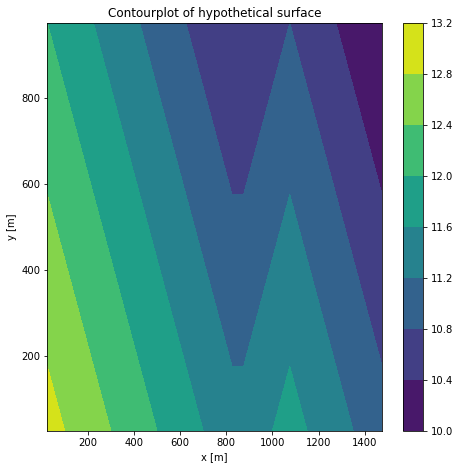

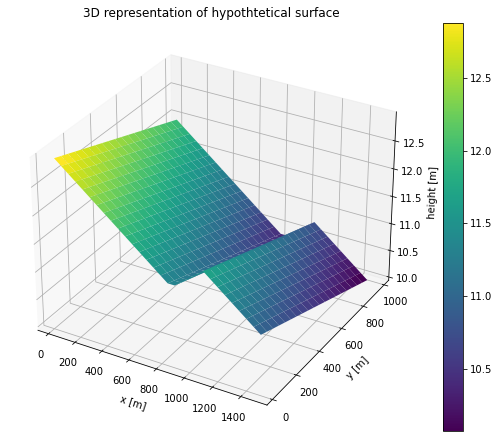

In [4]:
runfile('Grid_hypoth.py')
#geeft ons deze figuren en het grid dat we nodig hebben als grid
#convectie: grid[y,x] om zo met contour functies te kunnen werken!

Grid zoals hierboven aangemaakt is ZONDER de randen die nodig zijn om de randcondities te voldoen. Hiervoor bij alle niet outflowcellen een hoge waarde van hoogte om outflow te vermijden. Bij de outflowcel moet de gradient verder worden gevolgd voor continuiteit

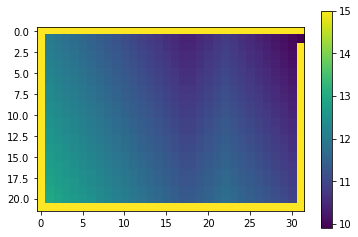

In [22]:
grid_imag = np.zeros((ny+2,nx+2))
grid_imag[1:-1,1:-1] = grid
#boundary conditions
grid_imag[:,0] = 15
grid_imag[:-1,-1] = 15
grid_imag[-2,-1] = grid[-1,-1] - (slopex*deltax) #dus wegdraineren met zelfde gradient
grid_imag[0,:] = 15
grid_imag[-1,:] = 15
plt.imshow(np.flipud(grid_imag))
plt.colorbar()

De ene outflow wordt dus duidelijk hier.

## De lokale loop over een neigbourhood

In [26]:
depths_imag = np.zeros((ny+2,nx+2))
fluxes_imag = np.zeros((4,ny+2,nx+2)) #elke cell krijgt maximaal 4 verschillende fluxes binnen
#voeg 0.2m water toe als test!
depths_imag[1:-1,1:-1] = 0.2
for j in np.arange(1,ny+1):
    for x in np.arange(1,nx+1):
        #hierbij conventie volgend van Figuur 1 in onze paper
        hneigb1 = grid_imag[j,i+1]
        hneigb2 = grid_imag[j+1,i]
        hneigb3 = grid_imag[j,i]
        hneigb4 = grid_imag[j-1,i]
        hneigb5 = grid_imag[j,i-1]
        NH_h = np.hstack([hneigb1,hneigb2,hneigb3,hneigb4,hneigb5])
